In [1]:
# Importing everything from lab3
import shutil
import glob
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import time
import skimage as sk
from skimage import io
from skimage import transform
from skimage import util
from skimage import exposure
import random
import math
from PIL import Image

# Part 1: Data Collection

Data for the UTKFace dataset will be downloaded from Kaggle and organized into folders for training, testing, validation by dividing the datsets randomly into 70%, 15%, 15% sections.

In [23]:
!rm -r /content/face-mask-dataset/facemask_train/
!rm -r /content/face-mask-dataset/facemask_train/
!rm -r utkface_parsed_val/
!rm -r utkface_dataset/

rm: cannot remove '/content/face-mask-dataset/facemask_train/': No such file or directory
rm: cannot remove '/content/face-mask-dataset/facemask_train/': No such file or directory
rm: cannot remove 'utkface_parsed_val/': No such file or directory
rm: cannot remove 'utkface_dataset/': No such file or directory


In [24]:
#Code Used to unzip UTK files
# pls dont hack me
!echo '{"username":"ahanafrakin","key":"1e3b55719b845be968593107beb54f23"}' > /root/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset

!mkdir face-mask-dataset
!unzip -qq face-mask-dataset -d face-mask-dataset
!rm *.zip


User cancelled operation
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
KeyboardInterrupt
mkdir: cannot create directory ‘face-mask-dataset’: File exists
unzip:  cannot find or open face-mask-dataset, face-mask-dataset.zip or face-mask-dataset.ZIP.
rm: cannot remove '*.zip': No such file or directory


In [25]:
try:
  os.mkdir('/content/facemask_train/')
  os.mkdir('/content/facemask_train/with_mask')
  os.mkdir('/content/facemask_train/without_mask')
  os.mkdir('/content/facemask_val')
  os.mkdir('/content/facemask_val/with_mask')
  os.mkdir('/content/facemask_val/without_mask')
  os.mkdir('/content/facemask_test')
  os.mkdir('/content/facemask_test/with_mask')
  os.mkdir('/content/facemask_test/without_mask')
except OSError:
  pass

In [26]:
random.seed(101)

for subdir, dirs, files in os.walk('/content/face-mask-dataset'):
  for file in files:
    if(file.endswith('.jpg')):
      pic_num = int(file.split('_')[2].split('.jpg')[0])
      if("with_mask" in file):
        if(pic_num%10 <=7):
          shutil.copy(os.path.join(subdir,file),'/content/facemask_train/with_mask')
        elif(pic_num%10 == 8):
          shutil.copy(os.path.join(subdir,file),'/content/facemask_val/with_mask')
        else:
          shutil.copy(os.path.join(subdir,file),'/content/facemask_test/with_mask')
      elif("without_mask" in file):
        if(pic_num%10 <=7):
          shutil.copy(os.path.join(subdir,file),'/content/facemask_train/without_mask')
        elif(pic_num%10 == 8):
          shutil.copy(os.path.join(subdir,file),'/content/facemask_val/without_mask')
        else:
          shutil.copy(os.path.join(subdir,file),'/content/facemask_test/without_mask')

In [27]:
# Rotate the image between 15 degrees to the left or right
def add_rotation(image_array):
  random_degree = random.uniform(-15, 15)
  return transform.rotate(image_array, random_degree)

# Adding random amount of noise to the picture
def add_noise(image_array):
  return util.random_noise(image_array)

# Adding random amount of gamma
def add_gamma(image_array):
  # Choosing random values to add
  gamma = random.uniform(0.5,0.9)
  gain = random.uniform(0.5,0.9)
  return exposure.adjust_gamma(image_array, gamma=gamma, gain=gain)


In [28]:
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
dataset_dest_train = '/content/facemask_train/'
dataset_dest_val = '/content/facemask_val/'
dataset_dest_test = '/content/facemask_test/'

dataset_train = torchvision.datasets.ImageFolder(dataset_dest_train, transform=transform)
dataset_val = torchvision.datasets.ImageFolder(dataset_dest_val, transform=transform)
dataset_test = torchvision.datasets.ImageFolder(dataset_dest_test, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                               num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                                               num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                               num_workers=1, shuffle=True)

In [29]:
#Need these to all be the same
print(len(dataset_train.class_to_idx))
print(len(dataset_val.class_to_idx))
print(len(dataset_test.class_to_idx))

2
2
2


In [30]:
vgg16 = torchvision.models.vgg16(pretrained=True)
if torch.cuda.is_available():
  vgg16.cuda()

train_vgg16 = []
val_vgg16 = []
test_vgg16 = []

start_time = time.time()
for img, label in train_loader:
  with torch.no_grad():
    if torch.cuda.is_available():
      train_vgg16.append((vgg16.features(img.cuda()),label))
end_time = time.time()
print(f"Total time taken: {end_time-start_time}")
for img, label in val_loader:
  with torch.no_grad():
    if torch.cuda.is_available():
      val_vgg16.append((vgg16.features(img.cuda()),label))
end_time = time.time()
print(f"Total time taken: {end_time-start_time}")
for img, label in test_loader:
  with torch.no_grad():
    if torch.cuda.is_available():
      test_vgg16.append((vgg16.features(img.cuda()),label))

end_time = time.time()
print(f"Total time taken: {end_time-start_time}")

#VGG16 output is of size 512,7,7

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time taken: 31.289613962173462
Total time taken: 35.4869966506958
Total time taken: 39.72425699234009


In [59]:
#Model 1
class CNN_VGG_Soft_Classifier(nn.Module):
  def __init__(self):
      super(CNN_VGG_Soft_Classifier, self).__init__()
      self.conv1 = nn.Conv2d(512,1024,3)
      self.pool = nn.MaxPool2d(2,2)
      self.fc1 = nn.Linear(1024*2*2, 256)
      self.fc2 = nn.Linear(256, 1)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = x.view(-1, 1024*2*2) #flatten feature data
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      x = x.squeeze(1)
      return x

#Soft max into 104 probabilites 

In [103]:
def get_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    outputs = model(imgs)
    for i, data in enumerate(outputs):
      total+=1
      if(outputs[i]>0 and labels[i]==1):
        correct+=1
      elif(outputs[i]<0 and labels[i]==0):
        correct+=1

  return correct / total

In [101]:
def train(model, train_loader, val_loader, num_epochs=1, learn_rate = 3e-4, save_output = True, model_path = "Vgg_soft"):

    torch.manual_seed(1000)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,weight_decay=0)
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc, val_acc = [], []
    
    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader):
          imgs, labels = data  
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

          out = model(imgs)             # forward pass
          loss = criterion(out, labels.float()) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          train_acc.append(get_accuracy(model, train_loader))
          val_acc.append(get_accuracy(model, val_loader))
          n += 1
        print(epoch, train_acc[-1], val_acc[-1])

        if save_output:
          np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
          np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
               
    return train_acc, val_acc

In [37]:
def plot_curve(path):
  import matplotlib.pyplot as plt
  train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  val_acc = np.loadtxt("{}_val_acc.csv".format(path))

  plt.title("Train vs Validation Accuracy")
  n = len(train_acc) # number of interations sets
  plt.plot(range(1,n+1), train_acc, label="Train")
  plt.plot(range(1,n+1), val_acc, label="Validation")
  plt.xlabel("Iterations of 10")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

In [66]:
use_cuda = True
baseline_model = BaselineCNN()

if use_cuda and torch.cuda.is_available():
  baseline_model.cuda()
  t_acc, v_acc = train(baseline_model, train_loader=train_loader, val_loader=val_loader, num_epochs=20, model_path="Baseline_CNN")
print(f"Train accuracy: {t_acc}, Validation accuracy: {v_acc}")

KeyboardInterrupt: ignored

In [105]:
use_cuda = True
vgg_model = CNN_VGG_Soft_Classifier()
if use_cuda and torch.cuda.is_available():
  vgg_model.cuda()
  t_acc, v_acc = train(vgg_model, train_loader=train_vgg16, val_loader=val_vgg16, num_epochs=10, save_output = True)

Training Started...
0 0.6871277299801456 0.6913907284768211
1 0.7749834546657842 0.7867549668874172
2 0.8623428193249504 0.8741721854304636
3 0.9182660489741893 0.9271523178807947
4 0.9490403706154864 0.9536423841059603
5 0.9657511581733951 0.9668874172185431
6 0.9748510919920582 0.9748344370860927
7 0.9808074123097287 0.9801324503311258
8 0.9824619457313037 0.9854304635761589
9 0.985109199205824 0.9867549668874173


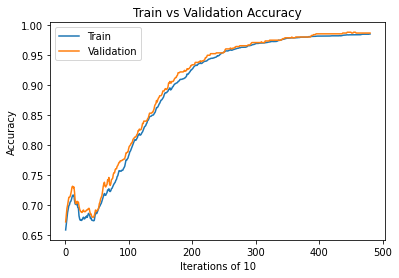

In [106]:
plot_curve("Vgg_soft")

In [107]:
torch.save(vgg_model.state_dict(),'vgg_model.pt')

In [111]:
start_time = time.time()
# mask_model.eval()
test_img = Image.open('/content/GettyImages-1092658864_thumb-732x549.jpg').convert("RGB")
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
# print(test_img.size)
test_img = transform(test_img)

test_img = vgg16.features(test_img.unsqueeze(0).cuda())
preds = vgg_model(test_img)
preds


tensor([1.4964], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor()])
testing_set = datasets.ImageFolder(root='/content/test', transform=transform)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=27,
                                               num_workers=1, shuffle=True)

test_data_alexnet = []
for img, label in test_loader:
  print(img.size())
  test = vgg16.features(img.cuda())
  print(test.size())
  print(vgg_model(test))



In [ ]:
#For the final we can try to pre-train on the IMDB data

In [134]:
test_model = CNN_VGG_Soft_Classifier()
test_model.load_state_dict(torch.load('/content/vgg_model.pt'))
test_model.eval()
test_model.to('cuda')

start_time = time.time()
# mask_model.eval()
test_img = Image.open('/content/GettyImages-1092658864_thumb-732x549.jpg').convert("RGB")
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
test_img = transform(test_img).cuda()

test_img = vgg16.to('cuda').features(test_img.unsqueeze(0))
preds = test_model(test_img)
preds
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.14510393142700195 seconds ---
